In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, LSTM, Dense, Bidirectional
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from IPython.core.interactiveshell import InteractiveShell
from sklearn.preprocessing import MinMaxScaler
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

<h4>Importing Datasets</h4>

In [39]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean= df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
            'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
    
    return df_filtered

In [40]:
# Create Dataframes for old and new
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)
df1.head()

new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)
df2.head()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


<h4>Creating Dictionary Keys</h4>

In [41]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [42]:
# Creating keys from data
print("Old Data keys:")
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

print("\nNew Data keys:")
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))

Old Data keys:
['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Si

<h4>Getting Top 5 ports keys</h4>

In [43]:
def getTop5Ports(keybunch):
    keybunch_pouch = []
    
    # Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
    key_row_counts = {key: len(keybunch[key]) for key in keybunch}

    # Sort the key_row_counts dictionary by value (number of rows) in descending order
    sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)

    # Get the top 5 keys with the most rows
    top_5_keys_tuple = sorted_key_row_counts[:5]

    # Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
    keybunch_subset = {}

    for key, row_count in top_5_keys_tuple:
        keybunch_subset[key] = keybunch[key][:5]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)
    
    # Return array of keys
    return keybunch_pouch

In [44]:
print('Old Dataset Keybunch:')
old_df = getTop5Ports(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getTop5Ports(filtered_dataframe2)

Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


In [45]:
# Accessing the highest count in the each keypouch, new and old.
sel_df = filtered_dataframe1[old_df[0]]
sel_df.head(5)
sel_df.tail(5)
sel_df.info()
print("\n")

latest_sel_df = filtered_dataframe2[new_df[0]]
latest_sel_df.head(5)
latest_sel_df.tail(5)
latest_sel_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1684,ECS010230100126,010000391908,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-22,40,HC,300.0
1685,ECS010230100126,010000380884,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-22,40,HC,300.0
1687,ECS010230100127,010000407833,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0
1686,ECS010230100127,010000390366,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0
1688,ECS010230100127,010000401385,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 0 to 1688
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1689 non-null   object        
 1   CNTR_ID     1689 non-null   object        
 2   POD_ID      1689 non-null   object        
 3   ETD_POL_D   1689 non-null   object        
 4   PARTY_ID    1689 non-null   object        
 5   PARTY_NAME  1689 non-null   object        
 6   POD         1689 non-null   datetime64[ns]
 7   CNTR_SIZE   1689 non-null   object        
 8   CNTR_TYPE   1689 non-null   object        
 9   RATE        1689 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 145.1+ KB




,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1708,ECS010230300113,010000512466,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-03,40,HC,260.0
1707,ECS010230300113,010000534846,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-03,40,HC,260.0
1709,ECS010230400203,010000544930,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-10,40,HC,300.0
1710,ECS010230400183,010000565100,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0
1711,ECS010230400183,010000554335,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1712 entries, 0 to 1711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1712 non-null   object        
 1   CNTR_ID     1712 non-null   object        
 2   POD_ID      1712 non-null   object        
 3   ETD_POL_D   1712 non-null   object        
 4   PARTY_ID    1712 non-null   object        
 5   PARTY_NAME  1712 non-null   object        
 6   POD         1712 non-null   datetime64[ns]
 7   CNTR_SIZE   1712 non-null   object        
 8   CNTR_TYPE   1712 non-null   object        
 9   RATE        1712 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 147.1+ KB


In [46]:
from sklearn.preprocessing import RobustScaler

# Select features
sel_feat = ['POD','RATE']
robust_df = sel_df[sel_feat].copy()  # make a copy to avoid SettingWithCopyWarning

# Robust Scaling
scaler = RobustScaler()
robust_df.loc[:, 'RATE'] = scaler.fit_transform(robust_df[['RATE']])
robust_df.head()

,POD,RATE
0,2005-10-03,2.777778
1,2005-10-03,2.777778
2,2005-10-07,2.777778
3,2005-10-07,2.777778
4,2005-10-14,2.777778


In [47]:
# Check if the DataFrame has any NaN values
if robust_df.isna().any().any():
    print("The DataFrame contains NaN values.")
else:
    print("The DataFrame does not contain NaN values.")

The DataFrame does not contain NaN values.


<h4>Interpolate missing values in between dates</h4>

In [48]:
# Remove duplicated dates and cost rows
robust_df = robust_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)

# Create a new dataframe with a date range from min to max date in your dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(start=robust_df['POD'].min(), end=robust_df['POD'].max())

# Merge the original dataframe with the new one. Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, robust_df, on='POD', how='left')  

# Perform spline interpolation
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(method='polynomial', order=1)

df_interpolated['RATE'] = df_interpolated['RATE'].round(3)

# Now we need to inverse the scaling
df_interpolated['RATE'] = scaler.inverse_transform(df_interpolated[['RATE']])

df_interpolated.head(5)
df_interpolated.tail(5)
df_interpolated.info()

,POD,RATE
0,2005-10-03,390.02
1,2005-10-04,390.02
2,2005-10-05,390.02
3,2005-10-06,390.02
4,2005-10-07,390.02


,POD,RATE
6371,2023-02-24,300.02
6372,2023-02-25,300.02
6373,2023-02-26,300.02
6374,2023-02-27,300.02
6375,2023-02-28,300.02


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6376 entries, 0 to 6375
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6376 non-null   datetime64[ns]
 1   RATE    6376 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 149.4 KB


<h4>Grouping it to week</h4>

In [49]:
from scipy import stats

# Create YearMonthWeek directly from the 'POD'
df_interpolated['YearMonthWeek'] = df_interpolated['POD'] - pd.to_timedelta(df_interpolated['POD'].dt.dayofweek, unit='D')

# Create a new dataframe with every week in the range
all_weeks = pd.date_range(start=df_interpolated['POD'].min(), end=df_interpolated['POD'].max(), freq='W')
all_weeks_df = pd.DataFrame(all_weeks, columns=['POD'])

# Create YearMonthWeek in all_weeks_df
all_weeks_df['YearMonthWeek'] = all_weeks_df['POD'] - pd.to_timedelta(all_weeks_df['POD'].dt.dayofweek, unit='D')

# Merge this with your original dataframe
merged_df = pd.merge(all_weeks_df, df_interpolated, on=['YearMonthWeek'], how='left')

# Now you can group by YearMonthWeek and compute your rate
grouped = merged_df.groupby(['YearMonthWeek'])

agg_df = pd.DataFrame(columns=['YearMonthWeek', 'Rate'])

for group_name, group_df in grouped:
    year_month_week = group_name

    # Skip if no data for this week
    if group_df['RATE'].isnull().all():
        continue

    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()

    # Calculate trimmed mean of RATE values
    rate_metric = stats.trim_mean(group_df['RATE'].dropna().values, 0.1) # trimming 10% from each end

    new_row = {
        'YearMonthWeek': year_month_week,
        'Rate': rate_metric
    }

    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)

agg_df = agg_df.sort_values(by='YearMonthWeek').reset_index(drop=True)
agg_df['Rate'] = agg_df['Rate'].round(2)

agg_df.head(15)
agg_df.tail(15)
agg_df.info()


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_28344\679132877.py:21: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_name, group_df in grouped:
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_28344\679132877.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_28344\679132877.py:41: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_28344\679132877.py:41: FutureWarning: The frame.append method is deprecated and will be remov

,YearMonthWeek,Rate
0,2005-10-03,390.02
1,2005-10-10,390.02
2,2005-10-17,390.02
3,2005-10-24,390.02
4,2005-10-31,390.02
5,2005-11-07,390.02
6,2005-11-14,390.02
7,2005-11-21,390.02
8,2005-11-28,390.02
9,2005-12-05,390.02


,YearMonthWeek,Rate
893,2022-11-14,149.99
894,2022-11-21,158.57
895,2022-11-28,191.43
896,2022-12-05,184.61
897,2022-12-12,211.52
898,2022-12-19,161.00
899,2022-12-26,159.17
900,2023-01-02,269.39
901,2023-01-09,300.02
902,2023-01-16,295.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   YearMonthWeek  908 non-null    datetime64[ns]
 1   Rate           908 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.3 KB


<h4>Latest datapoints from Latest dataframe for comparing after forecasting (Measure accuracy)</h4>

In [50]:
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD'] > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head(3)
new_dates_df.tail(3)
new_dates_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200077,010000419950,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
1,ECS010230200077,010000406570,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
2,ECS010230200078,010000432251,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-15,40,HC,260.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
20,ECS010230400203,010000544930,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-10,40,HC,300.0
21,ECS010230400183,010000565100,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0
22,ECS010230400183,010000554335,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      23 non-null     object        
 1   CNTR_ID     23 non-null     object        
 2   POD_ID      23 non-null     object        
 3   ETD_POL_D   23 non-null     object        
 4   PARTY_ID    23 non-null     object        
 5   PARTY_NAME  23 non-null     object        
 6   POD         23 non-null     datetime64[ns]
 7   CNTR_SIZE   23 non-null     object        
 8   CNTR_TYPE   23 non-null     object        
 9   RATE        23 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.9+ KB


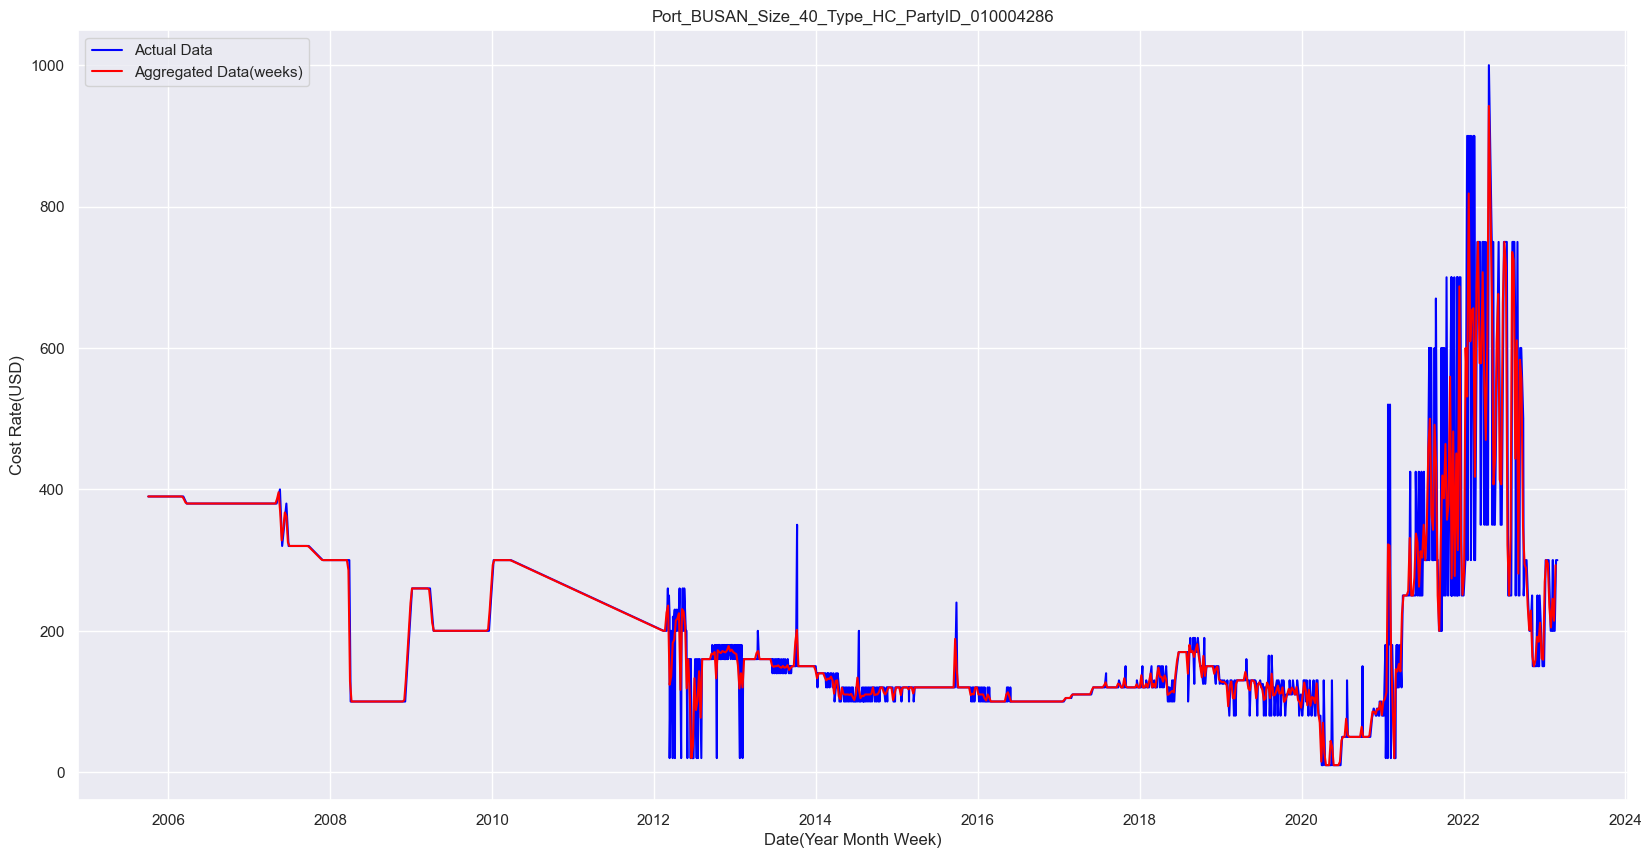

In [51]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonthWeek'], agg_df['Rate'], color='red', label="Aggregated Data(weeks)")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();

<h4>LSTM Regression<h4>

In [52]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Update create_dataset to handle multi-feature dataset
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def create_LSTM_model(trainX, trainY, testX, testY, epochs, lstm_layers):
    model = Sequential()

    # input layer
    model.add(Bidirectional(LSTM(lstm_layers[0], return_sequences=True), 
                            input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dropout(0.2))

    # hidden layers
    for i in range(1, len(lstm_layers)):
        model.add(Bidirectional(LSTM(lstm_layers[i], return_sequences=(i!=(len(lstm_layers)-1))))) 
        
    # output layer
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    
    history = model.fit(trainX, trainY, epochs=epochs, validation_data=(testX, testY), 
                        callbacks=[EarlyStopping(monitor='val_loss', patience=10)], 
                        verbose=2, shuffle=False)

    return model, history


def plot_train_val_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()

Training for 50 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/50
20/20 - 46s - loss: 0.0426 - val_loss: 0.0568 - 46s/epoch - 2s/step
Epoch 2/50
20/20 - 1s - loss: 0.0211 - val_loss: 0.0405 - 717ms/epoch - 36ms/step
Epoch 3/50
20/20 - 1s - loss: 0.0119 - val_loss: 0.0407 - 704ms/epoch - 35ms/step
Epoch 4/50
20/20 - 1s - loss: 0.0114 - val_loss: 0.0410 - 692ms/epoch - 35ms/step
Epoch 5/50
20/20 - 1s - loss: 0.0118 - val_loss: 0.0407 - 689ms/epoch - 34ms/step
Epoch 6/50
20/20 - 1s - loss: 0.0116 - val_loss: 0.0395 - 690ms/epoch - 35ms/step
Epoch 7/50
20/20 - 1s - loss: 0.0096 - val_loss: 0.0354 - 688ms/epoch - 34ms/step
Epoch 8/50
20/20 - 1s - loss: 0.0118 - val_loss: 0.0309 - 687ms/epoch - 34ms/step
Epoch 9/50
20/20 - 1s - loss: 0.0071 - val_loss: 0.0275 - 696ms/epoch - 35ms/step
Epoch 10/50
20/20 - 1s - loss: 0.0043 - val_loss: 0.0242 - 709ms/epoch - 35ms/step
Epoch 11/50
20/20 - 1s - loss: 0.0030 - val_loss: 0.0220 - 682ms/epoch - 34ms/step
Epo

9/9 [==============================] - 0s 9ms/step
Train Score: 19.20 RMSE for 50 epochs
Test Score: 109.64 RMSE for 50 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/50
20/20 - 37s - loss: 0.0437 - val_loss: 0.0589 - 37s/epoch - 2s/step
Epoch 2/50
20/20 - 1s - loss: 0.0223 - val_loss: 0.0388 - 559ms/epoch - 28ms/step
Epoch 3/50
20/20 - 1s - loss: 0.0116 - val_loss: 0.0388 - 530ms/epoch - 27ms/step
Epoch 4/50
20/20 - 1s - loss: 0.0112 - val_loss: 0.0381 - 526ms/epoch - 26ms/step
Epoch 5/50
20/20 - 1s - loss: 0.0111 - val_loss: 0.0361 - 522ms/epoch - 26ms/step
Epoch 6/50
20/20 - 1s - loss: 0.0099 - val_loss: 0.0328 - 521ms/epoch - 26ms/step
Epoch 7/50
20/20 - 1s - loss: 0.0079 - val_loss: 0.0257 - 523ms/epoch - 26ms/step
Epoch 8/50
20/20 - 1s - loss: 0.0038 - val_loss: 0.0172 - 546ms/epoch - 27ms/step
Epoch 9/50
20/20 - 1s - loss: 0.0013 - val_loss: 0.0150 - 595ms/epoch - 30ms/step
Epoch 10/50
20/20 - 1s - loss: 0.0010 - val_loss: 0.0170 - 528ms/epoch - 26m

9/9 [==============================] - 0s 7ms/step
Train Score: 23.19 RMSE for 50 epochs
Test Score: 102.51 RMSE for 50 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/50
20/20 - 30s - loss: 0.0402 - val_loss: 0.0501 - 30s/epoch - 2s/step
Epoch 2/50
20/20 - 0s - loss: 0.0183 - val_loss: 0.0376 - 431ms/epoch - 22ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0106 - val_loss: 0.0378 - 421ms/epoch - 21ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0108 - val_loss: 0.0361 - 423ms/epoch - 21ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0105 - val_loss: 0.0327 - 415ms/epoch - 21ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0090 - val_loss: 0.0267 - 411ms/epoch - 21ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0063 - val_loss: 0.0167 - 415ms/epoch - 21ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0021 - val_loss: 0.0096 - 410ms/epoch - 20ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0010 - val_loss: 0.0099 - 418ms/epoch - 21ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0014 - val_loss: 0.0138 - 415ms/epoch - 21ms/step
E

9/9 [==============================] - 0s 5ms/step
Train Score: 20.52 RMSE for 50 epochs
Test Score: 97.25 RMSE for 50 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Epoch 1/50
20/20 - 23s - loss: 0.0411 - val_loss: 0.0533 - 23s/epoch - 1s/step
Epoch 2/50
20/20 - 0s - loss: 0.0187 - val_loss: 0.0363 - 338ms/epoch - 17ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0111 - val_loss: 0.0343 - 321ms/epoch - 16ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0091 - val_loss: 0.0336 - 323ms/epoch - 16ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0092 - val_loss: 0.0315 - 324ms/epoch - 16ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0085 - val_loss: 0.0287 - 317ms/epoch - 16ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0074 - val_loss: 0.0253 - 317ms/epoch - 16ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0061 - val_loss: 0.0211 - 317ms/epoch - 16ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0042 - val_loss: 0.0165 - 315ms/epoch - 16ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0023 - val_loss: 0.0126 - 318ms/epoch - 16ms/step
Epoch 11/5

9/9 [==============================] - 0s 4ms/step
Train Score: 19.60 RMSE for 50 epochs
Test Score: 94.28 RMSE for 50 epochs
Training with LSTM layers: [4, 4, 2, 2]
Epoch 1/50
20/20 - 17s - loss: 0.0483 - val_loss: 0.0751 - 17s/epoch - 837ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0349 - val_loss: 0.0592 - 233ms/epoch - 12ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0228 - val_loss: 0.0449 - 237ms/epoch - 12ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0143 - val_loss: 0.0368 - 291ms/epoch - 15ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0105 - val_loss: 0.0344 - 287ms/epoch - 14ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0092 - val_loss: 0.0335 - 263ms/epoch - 13ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0088 - val_loss: 0.0327 - 228ms/epoch - 11ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0085 - val_loss: 0.0316 - 227ms/epoch - 11ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0082 - val_loss: 0.0304 - 234ms/epoch - 12ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0078 - val_loss: 0.0291 - 254ms/epoch - 13ms/step
Epoch 11/50
2

9/9 [==============================] - 0s 3ms/step
Train Score: 19.90 RMSE for 50 epochs
Test Score: 93.98 RMSE for 50 epochs
Training with LSTM layers: [2, 2]
Epoch 1/50
20/20 - 8s - loss: 0.0215 - val_loss: 0.0315 - 8s/epoch - 406ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0091 - val_loss: 0.0237 - 155ms/epoch - 8ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0060 - val_loss: 0.0222 - 150ms/epoch - 8ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0052 - val_loss: 0.0217 - 144ms/epoch - 7ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0050 - val_loss: 0.0211 - 138ms/epoch - 7ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0048 - val_loss: 0.0202 - 133ms/epoch - 7ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0043 - val_loss: 0.0193 - 133ms/epoch - 7ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0040 - val_loss: 0.0183 - 139ms/epoch - 7ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0039 - val_loss: 0.0174 - 140ms/epoch - 7ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0035 - val_loss: 0.0165 - 142ms/epoch - 7ms/step
Epoch 11/50
20/20 - 0s - loss:

9/9 [==============================] - 0s 2ms/step
Train Score: 19.48 RMSE for 50 epochs
Test Score: 86.92 RMSE for 50 epochs
Training for 100 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/100
20/20 - 48s - loss: 0.0403 - val_loss: 0.0515 - 48s/epoch - 2s/step
Epoch 2/100
20/20 - 1s - loss: 0.0191 - val_loss: 0.0400 - 717ms/epoch - 36ms/step
Epoch 3/100
20/20 - 1s - loss: 0.0113 - val_loss: 0.0406 - 713ms/epoch - 36ms/step
Epoch 4/100
20/20 - 1s - loss: 0.0117 - val_loss: 0.0402 - 728ms/epoch - 36ms/step
Epoch 5/100
20/20 - 1s - loss: 0.0116 - val_loss: 0.0387 - 710ms/epoch - 35ms/step
Epoch 6/100
20/20 - 1s - loss: 0.0092 - val_loss: 0.0320 - 688ms/epoch - 34ms/step
Epoch 7/100
20/20 - 1s - loss: 0.0068 - val_loss: 0.0250 - 667ms/epoch - 33ms/step
Epoch 8/100
20/20 - 1s - loss: 0.0040 - val_loss: 0.0200 - 687ms/epoch - 34ms/step
Epoch 9/100
20/20 - 1s - loss: 0.0028 - val_loss: 0.0233 - 678ms/epoch - 34ms/step
Epoch 10/100
20/20 - 1s - loss: 0

9/9 [==============================] - 0s 10ms/step
Train Score: 18.87 RMSE for 100 epochs
Test Score: 101.43 RMSE for 100 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/100
20/20 - 39s - loss: 0.0392 - val_loss: 0.0458 - 39s/epoch - 2s/step
Epoch 2/100
20/20 - 1s - loss: 0.0172 - val_loss: 0.0383 - 534ms/epoch - 27ms/step
Epoch 3/100
20/20 - 1s - loss: 0.0107 - val_loss: 0.0388 - 540ms/epoch - 27ms/step
Epoch 4/100
20/20 - 1s - loss: 0.0117 - val_loss: 0.0362 - 512ms/epoch - 26ms/step
Epoch 5/100
20/20 - 1s - loss: 0.0102 - val_loss: 0.0324 - 511ms/epoch - 26ms/step
Epoch 6/100
20/20 - 1s - loss: 0.0078 - val_loss: 0.0220 - 511ms/epoch - 26ms/step
Epoch 7/100
20/20 - 1s - loss: 0.0028 - val_loss: 0.0126 - 514ms/epoch - 26ms/step
Epoch 8/100
20/20 - 1s - loss: 9.0398e-04 - val_loss: 0.0145 - 524ms/epoch - 26ms/step
Epoch 9/100
20/20 - 1s - loss: 7.6654e-04 - val_loss: 0.0156 - 564ms/epoch - 28ms/step
Epoch 10/100
20/20 - 1s - loss: 9.7505e-04 - val_loss: 0

9/9 [==============================] - 0s 6ms/step
Train Score: 25.14 RMSE for 100 epochs
Test Score: 94.43 RMSE for 100 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/100
20/20 - 29s - loss: 0.0409 - val_loss: 0.0528 - 29s/epoch - 1s/step
Epoch 2/100
20/20 - 0s - loss: 0.0189 - val_loss: 0.0378 - 409ms/epoch - 20ms/step
Epoch 3/100
20/20 - 0s - loss: 0.0112 - val_loss: 0.0373 - 462ms/epoch - 23ms/step
Epoch 4/100
20/20 - 0s - loss: 0.0103 - val_loss: 0.0368 - 446ms/epoch - 22ms/step
Epoch 5/100
20/20 - 0s - loss: 0.0105 - val_loss: 0.0347 - 424ms/epoch - 21ms/step
Epoch 6/100
20/20 - 0s - loss: 0.0096 - val_loss: 0.0318 - 402ms/epoch - 20ms/step
Epoch 7/100
20/20 - 0s - loss: 0.0081 - val_loss: 0.0270 - 402ms/epoch - 20ms/step
Epoch 8/100
20/20 - 0s - loss: 0.0055 - val_loss: 0.0199 - 416ms/epoch - 21ms/step
Epoch 9/100
20/20 - 0s - loss: 0.0021 - val_loss: 0.0138 - 422ms/epoch - 21ms/step
Epoch 10/100
20/20 - 0s - loss: 8.8379e-04 - val_loss: 0.0132 - 427ms/epoc

9/9 [==============================] - 0s 5ms/step
Train Score: 21.46 RMSE for 100 epochs
Test Score: 101.53 RMSE for 100 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Epoch 1/100
20/20 - 22s - loss: 0.0456 - val_loss: 0.0674 - 22s/epoch - 1s/step
Epoch 2/100
20/20 - 0s - loss: 0.0273 - val_loss: 0.0471 - 328ms/epoch - 16ms/step
Epoch 3/100
20/20 - 0s - loss: 0.0157 - val_loss: 0.0377 - 323ms/epoch - 16ms/step
Epoch 4/100
20/20 - 0s - loss: 0.0111 - val_loss: 0.0364 - 333ms/epoch - 17ms/step
Epoch 5/100
20/20 - 0s - loss: 0.0099 - val_loss: 0.0361 - 322ms/epoch - 16ms/step
Epoch 6/100
20/20 - 0s - loss: 0.0099 - val_loss: 0.0352 - 313ms/epoch - 16ms/step
Epoch 7/100
20/20 - 0s - loss: 0.0096 - val_loss: 0.0339 - 322ms/epoch - 16ms/step
Epoch 8/100
20/20 - 0s - loss: 0.0091 - val_loss: 0.0323 - 322ms/epoch - 16ms/step
Epoch 9/100
20/20 - 0s - loss: 0.0085 - val_loss: 0.0302 - 333ms/epoch - 17ms/step
Epoch 10/100
20/20 - 0s - loss: 0.0076 - val_loss: 0.0275 - 332ms/epoch - 17ms/st

9/9 [==============================] - 0s 4ms/step
Train Score: 18.28 RMSE for 100 epochs
Test Score: 97.64 RMSE for 100 epochs
Training with LSTM layers: [4, 4, 2, 2]
Epoch 1/100
20/20 - 15s - loss: 0.0431 - val_loss: 0.0626 - 15s/epoch - 734ms/step
Epoch 2/100
20/20 - 0s - loss: 0.0247 - val_loss: 0.0436 - 239ms/epoch - 12ms/step
Epoch 3/100
20/20 - 0s - loss: 0.0139 - val_loss: 0.0349 - 228ms/epoch - 11ms/step
Epoch 4/100
20/20 - 0s - loss: 0.0100 - val_loss: 0.0329 - 228ms/epoch - 11ms/step
Epoch 5/100
20/20 - 0s - loss: 0.0088 - val_loss: 0.0323 - 227ms/epoch - 11ms/step
Epoch 6/100
20/20 - 0s - loss: 0.0084 - val_loss: 0.0315 - 223ms/epoch - 11ms/step
Epoch 7/100
20/20 - 0s - loss: 0.0081 - val_loss: 0.0304 - 222ms/epoch - 11ms/step
Epoch 8/100
20/20 - 0s - loss: 0.0077 - val_loss: 0.0291 - 222ms/epoch - 11ms/step
Epoch 9/100
20/20 - 0s - loss: 0.0073 - val_loss: 0.0278 - 223ms/epoch - 11ms/step
Epoch 10/100
20/20 - 0s - loss: 0.0069 - val_loss: 0.0262 - 222ms/epoch - 11ms/step
E

9/9 [==============================] - 0s 3ms/step
Train Score: 20.04 RMSE for 100 epochs
Test Score: 88.38 RMSE for 100 epochs
Training with LSTM layers: [2, 2]
Epoch 1/100
20/20 - 9s - loss: 0.0449 - val_loss: 0.0718 - 9s/epoch - 469ms/step
Epoch 2/100
20/20 - 0s - loss: 0.0345 - val_loss: 0.0597 - 144ms/epoch - 7ms/step
Epoch 3/100
20/20 - 0s - loss: 0.0251 - val_loss: 0.0489 - 140ms/epoch - 7ms/step
Epoch 4/100
20/20 - 0s - loss: 0.0174 - val_loss: 0.0406 - 140ms/epoch - 7ms/step
Epoch 5/100
20/20 - 0s - loss: 0.0124 - val_loss: 0.0357 - 141ms/epoch - 7ms/step
Epoch 6/100
20/20 - 0s - loss: 0.0098 - val_loss: 0.0333 - 138ms/epoch - 7ms/step
Epoch 7/100
20/20 - 0s - loss: 0.0088 - val_loss: 0.0321 - 149ms/epoch - 7ms/step
Epoch 8/100
20/20 - 0s - loss: 0.0083 - val_loss: 0.0313 - 144ms/epoch - 7ms/step
Epoch 9/100
20/20 - 0s - loss: 0.0079 - val_loss: 0.0307 - 139ms/epoch - 7ms/step
Epoch 10/100
20/20 - 0s - loss: 0.0076 - val_loss: 0.0300 - 136ms/epoch - 7ms/step
Epoch 11/100
20/20

9/9 [==============================] - 0s 2ms/step
Train Score: 20.93 RMSE for 100 epochs
Test Score: 90.37 RMSE for 100 epochs
Training for 150 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/150
20/20 - 46s - loss: 0.0397 - val_loss: 0.0440 - 46s/epoch - 2s/step
Epoch 2/150
20/20 - 1s - loss: 0.0171 - val_loss: 0.0389 - 713ms/epoch - 36ms/step
Epoch 3/150
20/20 - 1s - loss: 0.0108 - val_loss: 0.0396 - 766ms/epoch - 38ms/step
Epoch 4/150
20/20 - 1s - loss: 0.0119 - val_loss: 0.0369 - 759ms/epoch - 38ms/step
Epoch 5/150
20/20 - 1s - loss: 0.0091 - val_loss: 0.0305 - 761ms/epoch - 38ms/step
Epoch 6/150
20/20 - 1s - loss: 0.0060 - val_loss: 0.0214 - 712ms/epoch - 36ms/step
Epoch 7/150
20/20 - 1s - loss: 0.0020 - val_loss: 0.0183 - 868ms/epoch - 43ms/step
Epoch 8/150
20/20 - 1s - loss: 0.0014 - val_loss: 0.0149 - 762ms/epoch - 38ms/step
Epoch 9/150
20/20 - 1s - loss: 0.0015 - val_loss: 0.0164 - 769ms/epoch - 38ms/step
Epoch 10/150
20/20 - 1s - loss:

9/9 [==============================] - 0s 8ms/step
Train Score: 20.96 RMSE for 150 epochs
Test Score: 105.17 RMSE for 150 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/150
20/20 - 37s - loss: 0.0449 - val_loss: 0.0644 - 37s/epoch - 2s/step
Epoch 2/150
20/20 - 1s - loss: 0.0248 - val_loss: 0.0413 - 564ms/epoch - 28ms/step
Epoch 3/150
20/20 - 1s - loss: 0.0139 - val_loss: 0.0392 - 586ms/epoch - 29ms/step
Epoch 4/150
20/20 - 1s - loss: 0.0108 - val_loss: 0.0395 - 536ms/epoch - 27ms/step
Epoch 5/150
20/20 - 1s - loss: 0.0115 - val_loss: 0.0381 - 555ms/epoch - 28ms/step
Epoch 6/150
20/20 - 1s - loss: 0.0106 - val_loss: 0.0356 - 549ms/epoch - 27ms/step
Epoch 7/150
20/20 - 1s - loss: 0.0090 - val_loss: 0.0296 - 528ms/epoch - 26ms/step
Epoch 8/150
20/20 - 1s - loss: 0.0051 - val_loss: 0.0210 - 543ms/epoch - 27ms/step
Epoch 9/150
20/20 - 1s - loss: 0.0021 - val_loss: 0.0170 - 528ms/epoch - 26ms/step
Epoch 10/150
20/20 - 1s - loss: 0.0013 - val_loss: 0.0178 - 531ms

9/9 [==============================] - 0s 7ms/step
Train Score: 22.55 RMSE for 150 epochs
Test Score: 101.09 RMSE for 150 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Epoch 1/150
20/20 - 29s - loss: 0.0418 - val_loss: 0.0548 - 29s/epoch - 1s/step
Epoch 2/150
20/20 - 0s - loss: 0.0198 - val_loss: 0.0373 - 467ms/epoch - 23ms/step
Epoch 3/150
20/20 - 0s - loss: 0.0112 - val_loss: 0.0366 - 456ms/epoch - 23ms/step
Epoch 4/150
20/20 - 0s - loss: 0.0101 - val_loss: 0.0356 - 476ms/epoch - 24ms/step
Epoch 5/150
20/20 - 0s - loss: 0.0101 - val_loss: 0.0326 - 451ms/epoch - 23ms/step
Epoch 6/150
20/20 - 0s - loss: 0.0086 - val_loss: 0.0283 - 444ms/epoch - 22ms/step
Epoch 7/150
20/20 - 0s - loss: 0.0065 - val_loss: 0.0211 - 468ms/epoch - 23ms/step
Epoch 8/150
20/20 - 0s - loss: 0.0030 - val_loss: 0.0130 - 466ms/epoch - 23ms/step
Epoch 9/150
20/20 - 0s - loss: 7.1099e-04 - val_loss: 0.0102 - 449ms/epoch - 22ms/step
Epoch 10/150
20/20 - 0s - loss: 0.0011 - val_loss: 0.0130 - 481ms/epo

9/9 [==============================] - 0s 5ms/step
Train Score: 20.84 RMSE for 150 epochs
Test Score: 101.87 RMSE for 150 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Epoch 1/150
20/20 - 23s - loss: 0.0416 - val_loss: 0.0555 - 23s/epoch - 1s/step
Epoch 2/150
20/20 - 0s - loss: 0.0196 - val_loss: 0.0385 - 331ms/epoch - 17ms/step
Epoch 3/150
20/20 - 0s - loss: 0.0120 - val_loss: 0.0360 - 338ms/epoch - 17ms/step
Epoch 4/150
20/20 - 0s - loss: 0.0097 - val_loss: 0.0355 - 336ms/epoch - 17ms/step
Epoch 5/150
20/20 - 0s - loss: 0.0097 - val_loss: 0.0338 - 371ms/epoch - 19ms/step
Epoch 6/150
20/20 - 0s - loss: 0.0092 - val_loss: 0.0314 - 351ms/epoch - 18ms/step
Epoch 7/150
20/20 - 0s - loss: 0.0082 - val_loss: 0.0282 - 320ms/epoch - 16ms/step
Epoch 8/150
20/20 - 0s - loss: 0.0070 - val_loss: 0.0240 - 326ms/epoch - 16ms/step
Epoch 9/150
20/20 - 0s - loss: 0.0052 - val_loss: 0.0187 - 363ms/epoch - 18ms/step
Epoch 10/150
20/20 - 0s - loss: 0.0031 - val_loss: 0.0135 - 329ms/epoch - 16ms/st

9/9 [==============================] - 0s 4ms/step
Train Score: 19.87 RMSE for 150 epochs
Test Score: 95.58 RMSE for 150 epochs
Training with LSTM layers: [4, 4, 2, 2]
Epoch 1/150
20/20 - 17s - loss: 0.0380 - val_loss: 0.0528 - 17s/epoch - 847ms/step
Epoch 2/150
20/20 - 0s - loss: 0.0187 - val_loss: 0.0356 - 238ms/epoch - 12ms/step
Epoch 3/150
20/20 - 0s - loss: 0.0105 - val_loss: 0.0304 - 230ms/epoch - 12ms/step
Epoch 4/150
20/20 - 0s - loss: 0.0080 - val_loss: 0.0292 - 248ms/epoch - 12ms/step
Epoch 5/150
20/20 - 0s - loss: 0.0075 - val_loss: 0.0283 - 240ms/epoch - 12ms/step
Epoch 6/150
20/20 - 0s - loss: 0.0070 - val_loss: 0.0269 - 229ms/epoch - 11ms/step
Epoch 7/150
20/20 - 0s - loss: 0.0067 - val_loss: 0.0252 - 238ms/epoch - 12ms/step
Epoch 8/150
20/20 - 0s - loss: 0.0061 - val_loss: 0.0234 - 234ms/epoch - 12ms/step
Epoch 9/150
20/20 - 0s - loss: 0.0055 - val_loss: 0.0215 - 244ms/epoch - 12ms/step
Epoch 10/150
20/20 - 0s - loss: 0.0050 - val_loss: 0.0194 - 230ms/epoch - 12ms/step
E

9/9 [==============================] - 0s 3ms/step
Train Score: 18.82 RMSE for 150 epochs
Test Score: 86.48 RMSE for 150 epochs
Training with LSTM layers: [2, 2]
Epoch 1/150
20/20 - 8s - loss: 0.0423 - val_loss: 0.0630 - 8s/epoch - 378ms/step
Epoch 2/150
20/20 - 0s - loss: 0.0258 - val_loss: 0.0473 - 144ms/epoch - 7ms/step
Epoch 3/150
20/20 - 0s - loss: 0.0160 - val_loss: 0.0380 - 140ms/epoch - 7ms/step
Epoch 4/150
20/20 - 0s - loss: 0.0109 - val_loss: 0.0337 - 139ms/epoch - 7ms/step
Epoch 5/150
20/20 - 0s - loss: 0.0093 - val_loss: 0.0319 - 141ms/epoch - 7ms/step
Epoch 6/150
20/20 - 0s - loss: 0.0085 - val_loss: 0.0308 - 137ms/epoch - 7ms/step
Epoch 7/150
20/20 - 0s - loss: 0.0080 - val_loss: 0.0300 - 138ms/epoch - 7ms/step
Epoch 8/150
20/20 - 0s - loss: 0.0073 - val_loss: 0.0291 - 140ms/epoch - 7ms/step
Epoch 9/150
20/20 - 0s - loss: 0.0074 - val_loss: 0.0281 - 138ms/epoch - 7ms/step
Epoch 10/150
20/20 - 0s - loss: 0.0072 - val_loss: 0.0270 - 137ms/epoch - 7ms/step
Epoch 11/150
20/20

9/9 [==============================] - 0s 2ms/step
Train Score: 19.29 RMSE for 150 epochs
Test Score: 86.89 RMSE for 150 epochs


Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

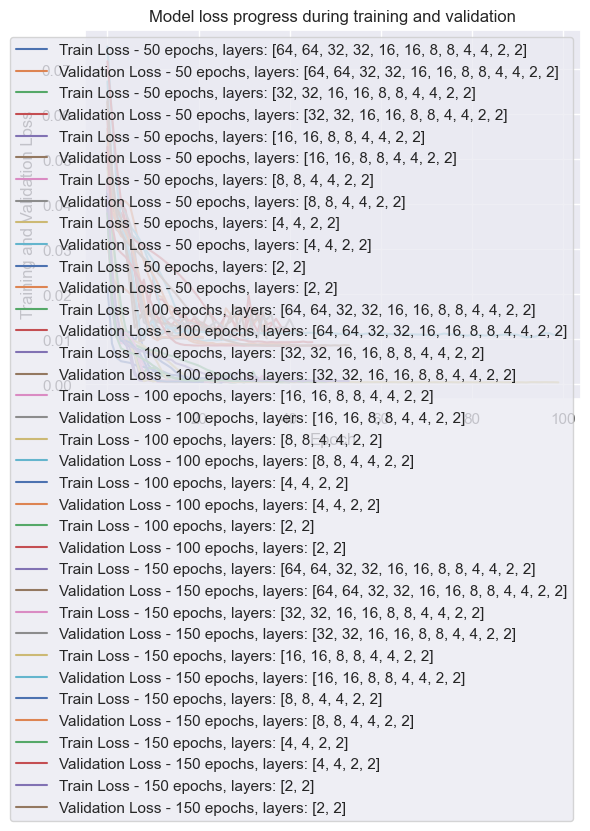

                                                    Train RMSE   Test RMSE
50 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4,...   19.199769  109.644197
50 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] l...   23.187501  102.513823
50 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers         20.517448   97.249227
50 epochs, [8, 8, 4, 4, 2, 2] layers                 19.596507   94.278211
50 epochs, [4, 4, 2, 2] layers                       19.896551   93.981613
50 epochs, [2, 2] layers                             19.477290   86.919582
100 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4...   18.868000  101.432319
100 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] ...   25.136946   94.425330
100 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers        21.461340  101.528578
100 epochs, [8, 8, 4, 4, 2, 2] layers                18.277820   97.636207
100 epochs, [4, 4, 2, 2] layers                      20.037485   88.375776
100 epochs, [2, 2] layers                            20.931781   90.368663
150 epochs, [64, 64, 32, 

In [54]:
# Normalize dataset for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the entire dataset
dataset = scaler.fit_transform(agg_df['Rate'].values.reshape(-1, 1))


# Split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X=t and Y=t+1, timestep  look_back
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, 1))
testX = np.reshape(testX, (testX.shape[0], look_back, 1))


epochs_list = [50, 100, 150]

lstm_layers_list = [
    [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
    [32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
    [16, 16, 8, 8, 4, 4, 2, 2],
    [8, 8, 4, 4, 2, 2],
    [4, 4, 2, 2],
    [2, 2]
]

rmse_results = {}

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')
    
    for lstm_layers in lstm_layers_list:
        print(f'Training with LSTM layers: {lstm_layers}')
        model, history = create_LSTM_model(trainX, trainY, testX, testY, epochs, lstm_layers)
        
        # Add the loss for this model to the plot
        plt.plot(history.history['loss'], label=f'Train Loss - {epochs} epochs, layers: {lstm_layers}')
        plt.plot(history.history['val_loss'], label=f'Validation Loss - {epochs} epochs, layers: {lstm_layers}')

        # Evalute LSTM Model
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)

        # inverse_transform
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY_orig = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testY_orig = scaler.inverse_transform([testY])

        # Calculate mean squared error
        trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:,0])
        print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
        testScore = calculate_RMSE(testY_orig[0], testPredict[:,0])
        print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

        rmse_results[f'{epochs} epochs, {lstm_layers} layers'] = {'Train RMSE': trainScore, 'Test RMSE': testScore}

# Configure and show the plot
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend()
plt.show();

# Convert the dictionary to a DataFrame for easy display
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)

<h4>Forecast the results</h4>

In [57]:
# Add check for 'RATE_actual' values to avoid division by zero
def compute_accuracy(row):
    if row['RATE_actual'] == 0:
        return np.nan
    else:
        error = abs(row['RATE_actual'] - row['RATE_forecasted'])
        error_proportion = error / row['RATE_actual']
        return (1 - error_proportion) * 100

def forecast_next_weeks(model, look_back, scaler, last_values, n_weeks):
    forecast = []
    for _ in range(n_weeks):
        # Reshape last_values to 2D array with one feature
        last_values_2d = np.array(last_values[-look_back:]).reshape(-1, 1)

        # Scale the last_values_2d to be between 0 and 1
        input_values_scaled = scaler.transform(last_values_2d)

        # Reshape to [samples, time steps, features]
        input_values_scaled = input_values_scaled.reshape((1, look_back, 1))

        # Predict the next value
        prediction = model.predict(input_values_scaled)

        # Rescale the prediction back to the original scale
        prediction_rescaled = scaler.inverse_transform(prediction)

        # Append the predicted value to the forecast list
        forecast.append(prediction_rescaled[0][0])

        # Append the predicted value to the last_values list to be used as input for the next prediction
        last_values.append(prediction_rescaled[0][0])
        # Drop the first value in the last_values list
        last_values.pop(0)

    return forecast


In [58]:
weeks = 12

# Ensure that 'YearMonthWeek' is a datetime object
agg_df['YearMonthWeek'] = pd.to_datetime(agg_df['YearMonthWeek'])
last_date = agg_df['YearMonthWeek'].iloc[-1]

last_values = list(agg_df['Rate'].values[-look_back:])
forecasted_values = forecast_next_weeks(model, look_back, scaler, last_values, weeks)
forecasted_dates = pd.date_range(start=last_date, periods=weeks+1, freq='W')[1:]

df_forecasted = pd.DataFrame({
    'POD': forecasted_dates,
    'RATE': forecasted_values
})

df_forecasted["RATE"] = df_forecasted["RATE"].round(2)

df_forecasted.head(5)
df_forecasted.tail(5)
df_forecasted.info()

1/1 [==============================] - 0s 22ms/step


,POD,RATE
0,2023-03-05,234.919998
1,2023-03-12,235.889999
2,2023-03-19,239.720001
3,2023-03-26,238.279999
4,2023-04-02,240.020004


,POD,RATE
7,2023-04-23,230.399994
8,2023-04-30,228.429993
9,2023-05-07,226.399994
10,2023-05-14,223.970001
11,2023-05-21,222.190002


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     12 non-null     datetime64[ns]
 1   RATE    12 non-null     float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 272.0 bytes


<h4>Comparing with actual updated against forecasted</h4>

In [59]:
comparison_df = pd.DataFrame(columns=['WeekStart', 'WeekEnd', 'POD_actual', 'RATE_forecasted', 'RATE_actual'])
df_forecasted['WeekEnd'] = df_forecasted['POD'] + pd.to_timedelta(7, unit='d')  

for _, row in df_forecasted.iterrows():
    mask = (new_dates_df['POD'] >= row['POD']) & (new_dates_df['POD'] < row['WeekEnd'])
    actual_dates_within_week = new_dates_df[mask]

    for _, actual_row in actual_dates_within_week.iterrows():
        comparison_df = comparison_df.append({
            'WeekStart': row['POD'],
            'WeekEnd': row['WeekEnd'],
            'POD_actual': actual_row['POD'],
            'RATE_forecasted': row['RATE'],
            'RATE_actual': actual_row['RATE']
        }, ignore_index=True)

# Remove duplicates
comparison_df = comparison_df.drop_duplicates(subset=['POD_actual', 'RATE_forecasted', 'RATE_actual']).reset_index(drop=True)

# Compute accuracy
comparison_df['accuracy'] = comparison_df.apply(compute_accuracy, axis=1)
comparison_df = comparison_df.dropna(subset=['accuracy'])

total_mean_accuracy = comparison_df['accuracy'].mean()
comparison_df
print(f'The mean accuracy is {total_mean_accuracy:.2f}%\n')

C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_28344\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_28344\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_28344\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_28344\3783945214.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append({
C:\U

,WeekStart,WeekEnd,POD_actual,RATE_forecasted,RATE_actual,accuracy
0,2023-03-05,2023-03-12,2023-03-08,234.919998,260.0,90.353845
1,2023-03-12,2023-03-19,2023-03-15,235.889999,260.0,90.726923
2,2023-03-19,2023-03-26,2023-03-19,239.720001,300.0,79.906667
3,2023-03-26,2023-04-02,2023-03-26,238.279999,260.0,91.646153
4,2023-03-26,2023-04-02,2023-04-01,238.279999,260.0,91.646153
5,2023-04-02,2023-04-09,2023-04-08,240.020004,260.0,92.315386
6,2023-04-09,2023-04-16,2023-04-12,232.470001,300.0,77.490000
7,2023-04-09,2023-04-16,2023-04-15,232.470001,260.0,89.411539
8,2023-04-16,2023-04-23,2023-04-20,231.639999,260.0,89.092307
9,2023-04-23,2023-04-30,2023-04-26,230.399994,300.0,76.799998


The mean accuracy is 86.07%



<h4>Visualise all, Conclusion</h4>

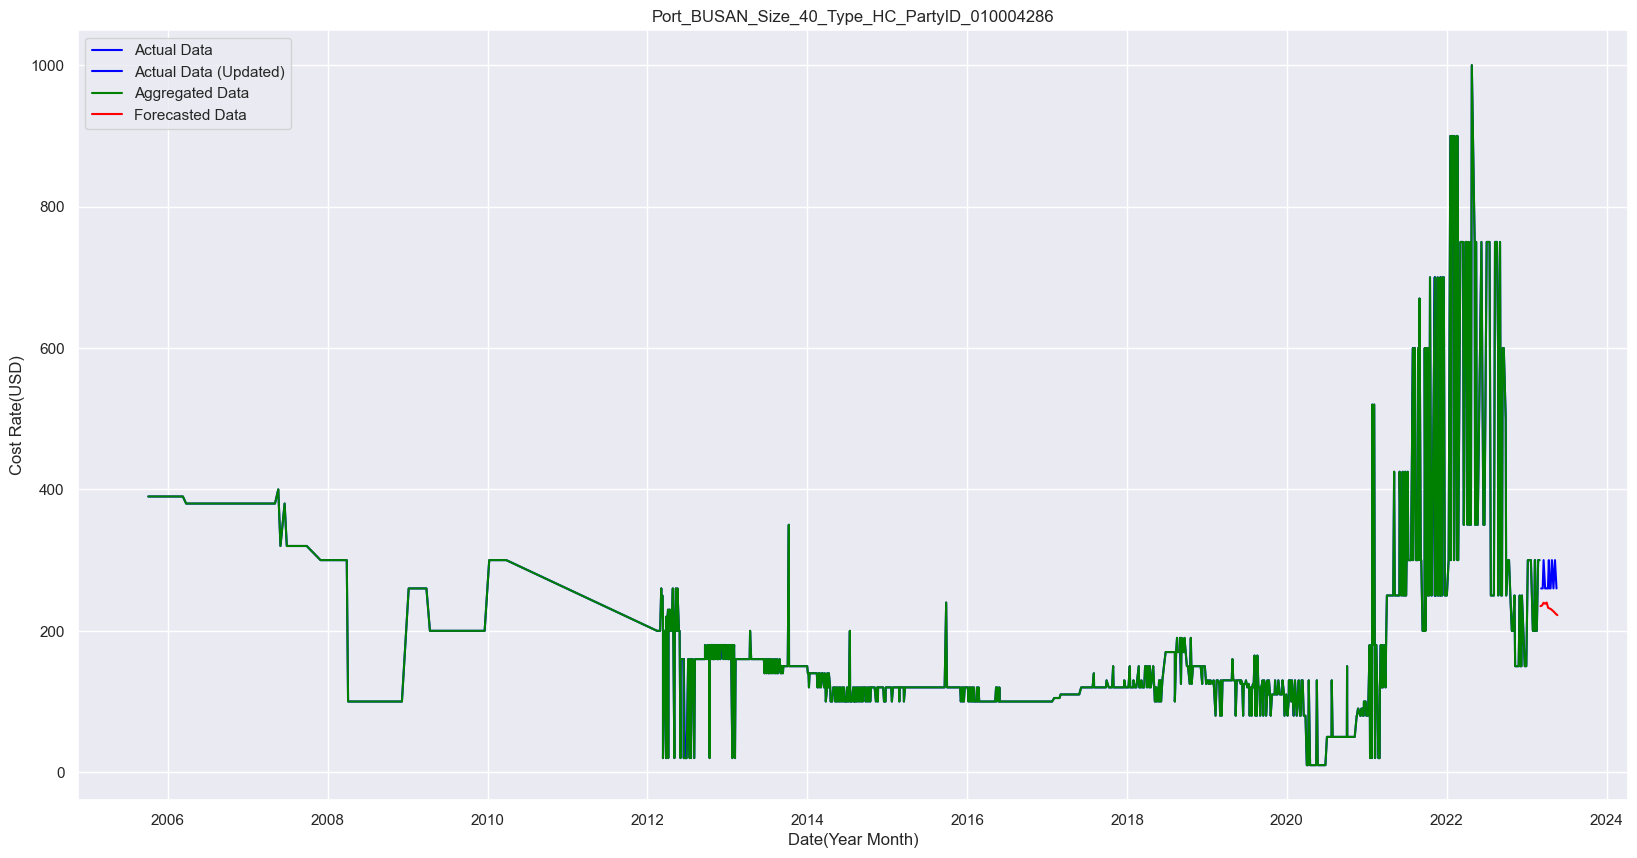

In [60]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(new_dates_df['POD'], new_dates_df['RATE'], color='blue', label="Actual Data (Updated)")

plt.plot(df_interpolated['POD'], df_interpolated['RATE'], color='green', label="Aggregated Data")
plt.plot(df_forecasted['POD'], df_forecasted['RATE'], color='red', label="Forecasted Data")

plt.xlabel('Date(Year Month)')
plt.ylabel('Cost Rate(USD)')
plt.title('Port_BUSAN_Size_40_Type_HC_PartyID_010004286')
plt.legend()
plt.show();